# Pattern Recognition - 9th Semester
## **Lab 2**. Speech Recognition with HMMs and RNNs

---
### Christos Dimopoulos - 03117037 <br />

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re
import os
import pandas as pd
from pomegranate import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from parser import *
from lstm import *
from plot_confusion_matrix import *

import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

## Step 9: Read FSDD audiofiles and preprocess the data

In [2]:
# Step 9: Read FSDD audiofiles and preprocess the data
X_train, X_test, y_train, y_test, spk_train, spk_test = parser('recordings', n_mfcc=6)

# Stratified Split of Train set to Train-Validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|█████████| 3000/3000 [00:18<00:00, 158.20it/s]

Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split


In [3]:
# Normalize Data
scale_fn = make_scale_fn(X_train)
X_train = scale_fn(X_train)
X_val = scale_fn(X_val)
X_test = scale_fn(X_test)

Normalization will be performed using mean: [-516.10384766   62.2330466    19.22393135    9.31668267  -19.07267138
  -11.22853204]
Normalization will be performed using std: [151.40037344  52.25086089  36.79629943  29.73001977  24.86775536
  23.27155712]


## Step 10: Define function that trains HMM models using the Forward-Backward Algorithm


In [18]:
# Step 10: Define function that trains HMM models using the Forward-Backward Algorithm
def forward_backward(X, n_states, n_mixtures, max_iter, gmm= True, threshold = 1e-9):
    dists = []
    for i in range(n_states):
        if gmm and n_mixtures>1:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(np.vstack(X)))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(np.vstack(X)))
        dists.append(a)

    # Define Matrix of initial probabilities
    starts = np.zeros(n_states)
    starts[0] = 1

    # Define Matrix of Final probabilities
    ends = np.zeros(n_states)
    ends[-1] = 1

    # Define Transition Matrix
    trans_mat = np.zeros((n_states,n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i == j or j == i+1:
                trans_mat[i,j] = 0.5  

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

    # Fit the model till convergence or until max iterations 
    model.fit(X, max_iterations=max_iter, algorithm = 'baum-welch', stop_threshold=threshold)

    return model

## Step 11: Train one GMM-HMM for each of the 10 digits

In [19]:
# Step 11: Train one GMM-HMM for each of the 10 digits

# Sort samples per digit
X_train_per_digit = []
for digit in range(10):
    indices = []
    # find samples of certain digit label
    for i in range(len(X_train)):
        if y_train[i] == digit:
            indices.append(i)
    digit_samples = np.take(X_train, indices, axis = 0) # collect samples

    # X_train_per_digit is a list of length 10 that contains numpy arrays of different size
    X_train_per_digit.append(digit_samples) # num_sequences x seq_length x feature_dimension

# Function that thrains one GMM-HMM for each digit
def fit_HMM(X, n_states, n_mixtures, max_iter, gmm= True, threshold = 1e-9):
    models = []
    for i in range(10):
        models.append(forward_backward(X[i], n_states, n_mixtures, max_iter, gmm, threshold))
    return models

## Step 12: Testing of Digit Recognition

In [20]:
# Step 12: Testing of Digit Recognition

# Define Functions predict and score that use GMM-HMMS models to find predictions with the Viterbi Algrithm
def predict_HMM(models, X, y, classes = 10):
    
    y_pred = []
    
    for sample in range(len(X)):
        log_likelihoods = []
        for model in range(classes):
            # Calculate log-likelihood  with Viterbi
            logp,_ = models[model].viterbi(X[sample])
            log_likelihoods.append(logp)
        y_pred.append(np.argmax(np.array(log_likelihoods))) # Maximum log-Likelihood
    return y_pred

# Returns Accuracy score and Confusion matrix
def score_HMM(models, X, y, classes = 10):
    y_pred = predict_HMM(models, X, y, classes)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return acc, cm

In [ ]:
from IPython.display import clear_output

#################### HYPERPARAMETER TUNING ####################

# Hyperparameter Values
n_states = [i for i in range(1,5)]
n_mixtures = [i for i in range(1,6)]
max_iter = [5,10,15,20,30]


# Train on train set and evaluate on validation set to find best hyperparameters
accs = []
hyperparameters = []

for nstates in n_states:
    for nmixtures in n_mixtures:
        for maxiter in max_iter:
            clear_output(wait=True)
            models = fit_HMM(X_train_per_digit, nstates, nmixtures, maxiter, True, 1e-9) # train HMMs
            acc, cm = score_HMM(models, X_val, y_val) # score on validation set
            
            print('Number of States:', nstates,'- Number of Gaussian Mixtures: ', nmixtures, '- Max Iterations:',maxiter,': ACCURACY:',acc)
            hyperparameters.append({'n_states':nstates, 'n_mixtures': nmixtures, 'max_iters':maxiter})
            accs.append(acc)

In [23]:
accs

[0.7703703703703704,
 0.7703703703703704,
 0.7703703703703704,
 0.7703703703703704,
 0.7703703703703704,
 0.8222222222222222,
 0.8296296296296296,
 0.8148148148148148,
 0.8166666666666667,
 0.8444444444444444,
 0.8574074074074074,
 0.8851851851851852,
 0.8722222222222222,
 0.8611111111111112,
 0.8796296296296297,
 0.9055555555555556,
 0.8796296296296297,
 0.9055555555555556,
 0.9166666666666666,
 0.8685185185185185,
 0.9462962962962963,
 0.924074074074074,
 0.924074074074074,
 0.9092592592592592,
 0.9222222222222223,
 0.8444444444444444,
 0.8537037037037037,
 0.8518518518518519,
 0.8481481481481481,
 0.8444444444444444,
 0.8722222222222222,
 0.912962962962963,
 0.912962962962963,
 0.9222222222222223,
 0.8981481481481481,
 0.9222222222222223,
 0.937037037037037,
 0.9555555555555556,
 0.9351851851851852,
 0.9629629629629629,
 0.9555555555555556,
 0.9518518518518518,
 0.9407407407407408,
 0.9388888888888889,
 0.9666666666666667,
 0.95,
 0.9648148148148148,
 0.9685185185185186,
 0.97777777

In [24]:
best_acc = np.max(accs)
best_hyperparam = hyperparameters[np.argmax(accs)]
print('Best Accuracy Score on Validation Set:', best_acc)
print('Best Hyperparameters:', best_hyperparam)

Best Accuracy Score on Validation Set: 0.987037037037037
Best Hyperparameters: {'n_states': 4, 'n_mixtures': 5, 'max_iters': 30}


In [25]:
# Define the GMM-HMMs with the best Hyperparameters and evaluate on test set
best_models = fit_HMM(X_train_per_digit, best_hyperparam['n_states'], best_hyperparam['n_mixtures'], best_hyperparam['max_iters'], True, 1e-9) # train HMMs
val_acc, val_cm = score_HMM(best_models, X_val, y_val)
test_acc, test_cm = score_HMM(best_models, X_test, y_test)
print('Best GMM-HMMs Performance:')
print('Validation Set Accuracy:',val_acc)
print('Test Set Accuracy:',test_acc)

Best GMM-HMMs Performance:
Validation Set Accuracy: 0.9777777777777777
Test Set Accuracy: 0.99


## Step 13: Confusion Matrices

Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 53  0  0  0  1  0  0  0  0]
 [ 1  0 53  0  0  0  0  0  0  0]
 [ 0  0  1 51  0  0  1  0  1  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  1  1]
 [ 1  0  0  1  0  1  0 51  0  0]
 [ 0  0  0  1  0  0  1  0 52  0]
 [ 0  0  0  0  0  0  0  0  0 54]]


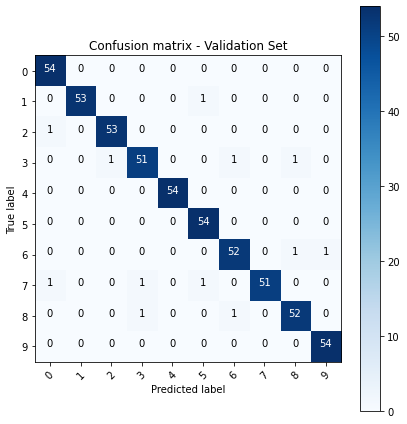

In [6]:
# Step 13: Confusion Matrices
plt.rcParams['figure.figsize'] = [6,6]
plot_confusion_matrix(val_cm, classes = [i for i in range(10)],
                          normalize=False,
                          title='Confusion matrix - Validation Set',
                          cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  2  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


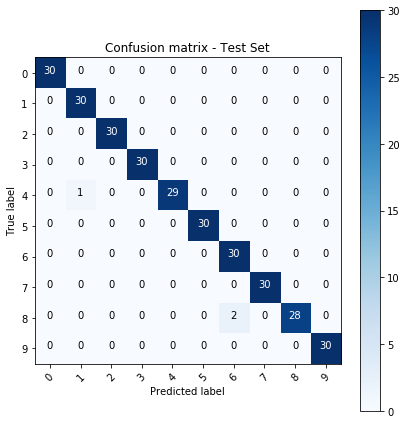

In [31]:
plot_confusion_matrix(test_cm, classes = [i for i in range(10)],
                          normalize=False,
                          title='Confusion matrix - Test Set',
                          cmap=plt.cm.Blues)

## Step 14: RNNs

In [4]:
##############################################################################################
# Step 14: Recurrent Neural Networks - LSTMs

# Define Datasets
train_set = FrameLevelDataset(X_train, y_train)
val_set = FrameLevelDataset(X_val, y_val)
test_set = FrameLevelDataset(X_test, y_test)

BATCH_SIZE = 64

# Define Dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# Function that Trains a Neural Network
def train_NN(dataloader, model, criterion, optimizer, packed = False):
    total_loss = 0.0
    model.train() # switch to train mode
    
    for idx, batch in enumerate(dataloader, 1):
        
        # Unpack Batch
        (inputs, labels, lengths) = batch
        
        # Zero Gradients
        optimizer.zero_grad()
        
        if packed: # allign labels with sorted input
            # Forward Pass
            y_preds, indices = model(inputs, lengths)

            # Compute Loss
            loss = criterion(y_preds, labels[indices])
        else:
            # Forward Pass
            y_preds = model(inputs, lengths)

            # Compute Loss
            loss = criterion(y_preds, labels)

        # Back-Propagate Loss
        loss.backward()

        # Update Loss
        optimizer.step()

        # Collect Loss
        total_loss += loss.data.item()

    return total_loss/idx

# Function that Evaluates a Neural Network
def eval_NN(dataloader, model, criterion, packed = False):
    
    total_loss = 0.0
    model.eval() # switch to evaluation mode
    
    y_gold = []
    y_pred = []
    
    with torch.no_grad(): # don't keep gradients
        for idx, batch in enumerate(dataloader, 1):
            
            (inputs, labels, lengths) = batch
            
            
            if packed: # allign labels with sorted input
                # Forward Pass
                y_preds, indices = model(inputs, lengths)

                # Compute Loss
                loss = criterion(y_preds, labels[indices])
            else:
                # Forward Pass
                y_preds = model(inputs, lengths)

                # Compute Loss
                loss = criterion(y_preds, labels)
            
            # Prediction: argmax of aposterioris
            prediction = torch.argmax(y_preds, dim=1)
            
            # Collect Loss and labels
            total_loss += loss.data.item()
            
            y_pred.append(prediction.numpy())
            if packed:
                y_gold.append(labels[indices].numpy())
            else:
                y_gold.append(labels.numpy())

    return total_loss / idx, (y_gold, y_pred)

In [19]:
# Define a simple LSTM Network at first
n_features = X_train[0].shape[1]
LSTM_model = BasicLSTM(input_dim = n_features, hidden_size = 64, output_dim = 10, num_layers = 1, bidirectional=False, dropout = 0)

# Define Hyperparameters
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)

# Begin Training of LSTM and evaluation on validation set
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # fit model
    train_loss = train_NN(train_loader, LSTM_model, criterion, optimizer)
    
    print('EPOCH',str(epoch),':')
    print('Training Loss:',str(train_loss))    
    train_losses.append(train_loss)
    
    # evaluate on validation set - comment out if unwanted
    val_loss, (y_gold, y_pred) = eval_NN(val_loader, LSTM_model, criterion)
    print('Validation Loss:',str(val_loss))
    val_losses.append(val_loss)
    

EPOCH 0 :
Training Loss: 2.2388661679099586
Validation Loss: 2.1034371058146157
EPOCH 1 :
Training Loss: 1.8402424559873694
Validation Loss: 1.4974847767088149
EPOCH 2 :
Training Loss: 1.3527894510942347
Validation Loss: 1.1117381387286716
EPOCH 3 :
Training Loss: 0.9915600752129274
Validation Loss: 0.787888248761495
EPOCH 4 :
Training Loss: 0.7392971533186296
Validation Loss: 0.6686807837751176
EPOCH 5 :
Training Loss: 0.5921579836045995
Validation Loss: 0.5060556067360772
EPOCH 6 :
Training Loss: 0.47927527304957895
Validation Loss: 0.4352358712090386
EPOCH 7 :
Training Loss: 0.3869651652434293
Validation Loss: 0.36171078350808883
EPOCH 8 :
Training Loss: 0.3193664607756278
Validation Loss: 0.3193260447846519
EPOCH 9 :
Training Loss: 0.28356681062894706
Validation Loss: 0.2815575864579942
EPOCH 10 :
Training Loss: 0.2701360228307107
Validation Loss: 0.2891036503844791
EPOCH 11 :
Training Loss: 0.22686184811241486
Validation Loss: 0.2202541786763403
EPOCH 12 :
Training Loss: 0.1776323

EPOCH 99 :
Training Loss: 0.005140390627168338
Validation Loss: 0.06982193553509812


In [11]:
# Function that plots train and validation losses for given epochs
def plot_losses(epochs, train_loss, val_loss, title = 'Losses per Epoch'):
    n = np.arange(epochs)
    plt.plot(n, train_loss, label = "Train Loss")
    plt.plot(n, val_loss, label = "Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

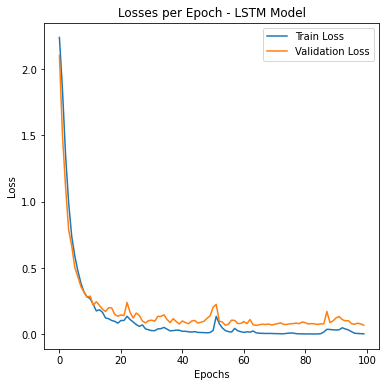

In [20]:
plot_losses(EPOCHS, train_losses, val_losses, title = 'Losses per Epoch - LSTM Model')

In [21]:
# Add Dropout and L2-Regularization to our LSTM Model
LSTM_model2 = BasicLSTM(input_dim = n_features, hidden_size = 64, 
                       output_dim = 10, num_layers = 1, bidirectional=False, dropout = 0.5) # 50% dropout prob

# L2-Regularization Optimizer 
optimizer = torch.optim.Adam(LSTM_model2.parameters(), lr=0.001, weight_decay=1e-5)

# Begin Training of LSTM and evaluation on validation set
train_losses2 = []
val_losses2 = []

for epoch in range(EPOCHS):
    # fit model
    train_loss = train_NN(train_loader, LSTM_model2, criterion, optimizer)
    
    print('EPOCH',str(epoch),':')
    print('Training Loss:',str(train_loss))    
    train_losses2.append(train_loss)
    
    # evaluate on validation set - comment out if unwanted
    val_loss, (y_gold, y_pred) = eval_NN(val_loader, LSTM_model2, criterion)
    print('Validation Loss:',str(val_loss))
    val_losses2.append(val_loss)

EPOCH 0 :
Training Loss: 2.25604046793545
Validation Loss: 2.152531517876519
EPOCH 1 :
Training Loss: 1.8974842639530407
Validation Loss: 1.570516308148702
EPOCH 2 :
Training Loss: 1.4063653455061071
Validation Loss: 1.180164098739624
EPOCH 3 :
Training Loss: 1.0936709765125723
Validation Loss: 0.8808628651830885
EPOCH 4 :
Training Loss: 0.8398823106990141
Validation Loss: 0.7505068911446465
EPOCH 5 :
Training Loss: 0.6486123099046595
Validation Loss: 0.5468860897752974
EPOCH 6 :
Training Loss: 0.5384979353231543
Validation Loss: 0.4549835953447554
EPOCH 7 :
Training Loss: 0.4579734144841923
Validation Loss: 0.39060678746965194
EPOCH 8 :
Training Loss: 0.3807714121306644
Validation Loss: 0.30723657872941756
EPOCH 9 :
Training Loss: 0.29690176336204305
Validation Loss: 0.24860712885856628
EPOCH 10 :
Training Loss: 0.24543050019180074
Validation Loss: 0.27290745907359654
EPOCH 11 :
Training Loss: 0.23255631568677285
Validation Loss: 0.2154552158382204
EPOCH 12 :
Training Loss: 0.16543291

EPOCH 99 :
Training Loss: 0.010864278041374157
Validation Loss: 0.06812236059664024


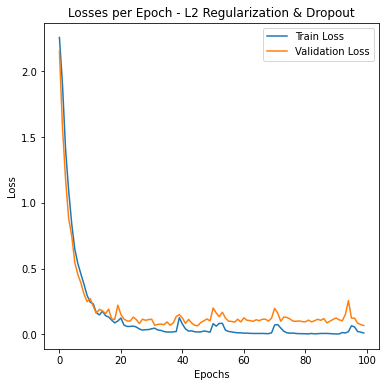

In [22]:
plot_losses(EPOCHS, train_losses2, val_losses2, title = 'Losses per Epoch - L2 Regularization & Dropout')

In [26]:
# Train Model with Early Stopping
LSTM_model3 = BasicLSTM(input_dim = n_features, hidden_size = 64, 
                       output_dim = 10, num_layers = 1, bidirectional=False, dropout = 0.5) # 50% dropout prob

# L2-Regularization Optimizer 
optimizer = torch.optim.Adam(LSTM_model3.parameters(), lr=0.001, weight_decay=1e-5)

# Begin Training of LSTM and evaluation on validation set
train_losses3 = []
val_losses3 = []

counter = 0
max_increases = 5
best_val_loss = 9999999

for epoch in range(EPOCHS):
    # fit model
    train_loss = train_NN(train_loader, LSTM_model3, criterion, optimizer)
    
    print('EPOCH',str(epoch),':')
    print('Training Loss:',str(train_loss))    
    train_losses3.append(train_loss)
    
    # evaluate on validation set - comment out if unwanted
    val_loss, (y_gold, y_pred) = eval_NN(val_loader, LSTM_model3, criterion)
    print('Validation Loss:',str(val_loss))
    val_losses3.append(val_loss)
    
    # Apply Early Stopping Techniques
    if val_loss < best_val_loss:
        torch.save(LSTM_model3, "./early_model") # checkpoint
        best_val_loss = val_loss
        counter = 0 # reset counter
    else:
        counter += 1
    
    if counter == max_increases: # 10 times in a row no loss improvement - break
        print('Early Stopping')
        break

EPOCH 0 :
Training Loss: 2.2503117322921753
Validation Loss: 2.115712218814426
EPOCH 1 :
Training Loss: 1.8474880982847774
Validation Loss: 1.600817124048869
EPOCH 2 :
Training Loss: 1.52972372489817
Validation Loss: 1.3981400463316176
EPOCH 3 :
Training Loss: 1.3027952103053821
Validation Loss: 1.1764950619803534
EPOCH 4 :
Training Loss: 1.0889599726480597
Validation Loss: 0.9692170156372918
EPOCH 5 :
Training Loss: 0.8899083628373987
Validation Loss: 0.772911873128679
EPOCH 6 :
Training Loss: 0.7107285822139067
Validation Loss: 0.6113852792316012
EPOCH 7 :
Training Loss: 0.5425707803053015
Validation Loss: 0.4832060933113098
EPOCH 8 :
Training Loss: 0.4947713552152409
Validation Loss: 0.43091001444392735
EPOCH 9 :
Training Loss: 0.40361281966461854
Validation Loss: 0.3736518753899468
EPOCH 10 :
Training Loss: 0.36001169155625734
Validation Loss: 0.3313024044036865
EPOCH 11 :
Training Loss: 0.31392686594935026
Validation Loss: 0.3360854933659236
EPOCH 12 :
Training Loss: 0.26688862986

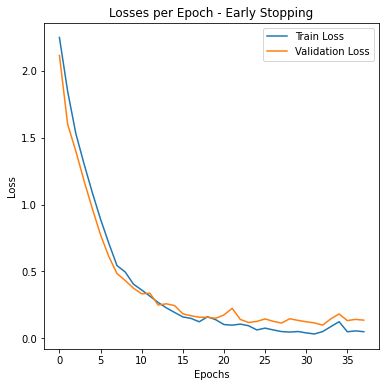

In [27]:
plot_losses(len(train_losses3), train_losses3, val_losses3, title = 'Losses per Epoch - Early Stopping')

In [14]:
# Use a Bidirectional LSTM with Early Stopping, Dropout and Regularization
bi_LSTM = BasicLSTM(input_dim = n_features, hidden_size = 64, 
                       output_dim = 10, num_layers = 1, bidirectional=True, dropout = 0.5) # 50% dropout prob

# L2-Regularization Optimizer 
optimizer = torch.optim.Adam(bi_LSTM.parameters(), lr=0.001, weight_decay=1e-5)

# Begin Training of LSTM and evaluation on validation set
train_losses4 = []
val_losses4 = []

counter = 0
max_increases = 5
best_val_loss = 9999999

for epoch in range(EPOCHS):
    # fit model
    train_loss = train_NN(train_loader, bi_LSTM, criterion, optimizer)
    
    print('EPOCH',str(epoch),':')
    print('Training Loss:',str(train_loss))    
    train_losses4.append(train_loss)
    
    # evaluate on validation set - comment out if unwanted
    val_loss, (y_gold, y_pred) = eval_NN(val_loader, bi_LSTM, criterion)
    print('Validation Loss:',str(val_loss))
    val_losses4.append(val_loss)
    
    # Apply Early Stopping Techniques
    if val_loss < best_val_loss:
        torch.save(bi_LSTM, "./early_bimodel") # checkpoint
        best_val_loss = val_loss
        counter = 0 # reset counter
    else:
        counter += 1
    
    if counter == max_increases: # 10 times in a row no loss improvement - break
        print('Early Stopping')
        break

EPOCH 0 :
Training Loss: 2.183830745079938
Validation Loss: 1.9085213475757175
EPOCH 1 :
Training Loss: 1.4422320741064407
Validation Loss: 0.9833844436539544
EPOCH 2 :
Training Loss: 0.7716210572158589
Validation Loss: 0.5703434811698066
EPOCH 3 :
Training Loss: 0.4933035364922355
Validation Loss: 0.40548678239186603
EPOCH 4 :
Training Loss: 0.3890313067856957
Validation Loss: 0.3109062612056732
EPOCH 5 :
Training Loss: 0.28439253130379843
Validation Loss: 0.25660452908939785
EPOCH 6 :
Training Loss: 0.22349848203799305
Validation Loss: 0.2081081039375729
EPOCH 7 :
Training Loss: 0.18138017834109418
Validation Loss: 0.18721077094475427
EPOCH 8 :
Training Loss: 0.16997711667243173
Validation Loss: 0.14970544891224968
EPOCH 9 :
Training Loss: 0.12845765536322312
Validation Loss: 0.14884572310580146
EPOCH 10 :
Training Loss: 0.11126924525288974
Validation Loss: 0.14287335467007425
EPOCH 11 :
Training Loss: 0.10671379022738513
Validation Loss: 0.11399996570414966
EPOCH 12 :
Training Loss:

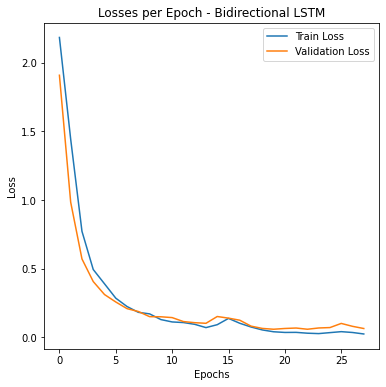

In [16]:
plot_losses(len(train_losses4), train_losses4, val_losses4, title = 'Losses per Epoch - Bidirectional LSTM')

In [16]:
# Print Accuracy and Confusion Matrix of Best Model
best_model = torch.load('early_bimodel')

# evaluate on val and test sets
val_loss, (val_gold, val_pred) = eval_NN(val_loader, best_model, criterion)
test_loss, (test_gold, test_pred) = eval_NN(test_loader, best_model, criterion)

# Accuracies and Confusion Matrices
acc_val = accuracy_score(np.concatenate(val_gold), np.concatenate(val_pred))
acc_test = accuracy_score(np.concatenate(test_gold), np.concatenate(test_pred))
cm_val = confusion_matrix(np.concatenate(val_gold), np.concatenate(val_pred))
cm_test = confusion_matrix(np.concatenate(test_gold), np.concatenate(test_pred))

print('Best Model:')
print('Validation Set Accuracy:', acc_val)
print('Test Set Accuracy:', acc_test)

Best Model:
Validation Set Accuracy: 0.9814814814814815
Test Set Accuracy: 0.97


Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  2  0  0]
 [ 0  0 54  0  0  0  0  0  0  0]
 [ 0  0  0 48  0  0  6  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  0  1  0  0  0  1  0 52  0]
 [ 0  0  0  0  0  0  0  0  0 54]]


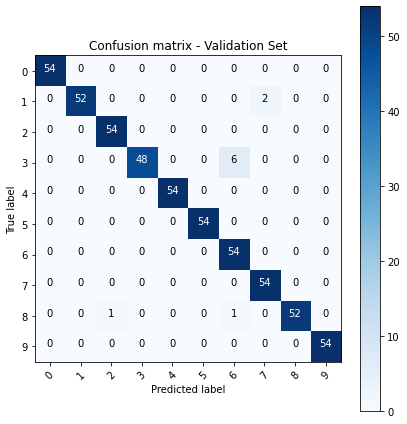

In [17]:
plt.rcParams['figure.figsize'] = [6,6]
plot_confusion_matrix(cm_val, classes = [i for i in range(10)],
                          normalize=False,
                          title='Confusion matrix - Validation Set',
                          cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  1  0  0  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 29  1  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 1  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  1  0  0  4  0 25  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


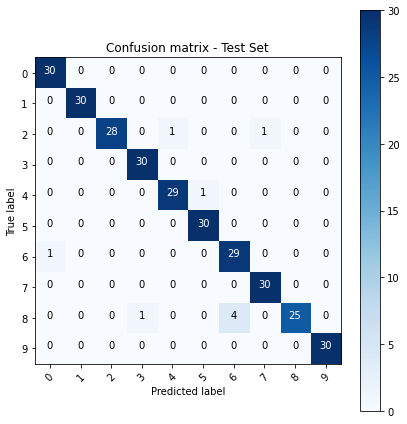

In [25]:
plot_confusion_matrix(cm_test, classes = [i for i in range(10)],
                          normalize=False,
                          title='Confusion matrix - Test Set',
                          cmap=plt.cm.Blues)

In [7]:
# (Bonus) Use pack_padded_sequence for faster computations
n_features = X_train[0].shape[1]
EPOCHS = 100
criterion = nn.CrossEntropyLoss()

bi_LSTM_packed = BasicLSTM_packed(input_dim = n_features, hidden_size = 64, 
                       output_dim = 10, num_layers = 1, bidirectional=True, dropout = 0.5) # 50% dropout prob

# L2-Regularization Optimizer 
optimizer = torch.optim.Adam(bi_LSTM_packed.parameters(), lr=0.001, weight_decay=1e-5)

# Begin Training of LSTM and evaluation on validation set
train_losses5 = []
val_losses5 = []

counter = 0
max_increases = 5
best_val_loss = 9999999

for epoch in range(EPOCHS):
    # fit model
    train_loss = train_NN(train_loader, bi_LSTM_packed, criterion, optimizer, packed=True)
    
    print('EPOCH',str(epoch),':')
    print('Training Loss:',str(train_loss))    
    train_losses5.append(train_loss)
    
    # evaluate on validation set - comment out if unwanted
    val_loss, (y_gold, y_pred) = eval_NN(val_loader, bi_LSTM_packed, criterion, packed=True)
    print('Validation Loss:',str(val_loss))
    val_losses5.append(val_loss)
    
    # Apply Early Stopping Techniques
    if val_loss < best_val_loss:
        torch.save(bi_LSTM_packed, "./early_bimodel_packed") # checkpoint
        best_val_loss = val_loss
        counter = 0 # reset counter
    else:
        counter += 1
    
    if counter == max_increases: # 10 times in a row no loss improvement - break
        print('Early Stopping')
        break

EPOCH 0 :
Training Loss: 2.144694258184994
Validation Loss: 1.825404206911723
EPOCH 1 :
Training Loss: 1.3563737939385807
Validation Loss: 0.9037824935383267
EPOCH 2 :
Training Loss: 0.7309480923063615
Validation Loss: 0.5283276504940457
EPOCH 3 :
Training Loss: 0.48051665285054374
Validation Loss: 0.3875238398710887
EPOCH 4 :
Training Loss: 0.3386504527400522
Validation Loss: 0.2719501968887117
EPOCH 5 :
Training Loss: 0.2566232102758744
Validation Loss: 0.21300988644361496
EPOCH 6 :
Training Loss: 0.20013324916362762
Validation Loss: 0.18592419475317
EPOCH 7 :
Training Loss: 0.166130208355539
Validation Loss: 0.15408691846662098
EPOCH 8 :
Training Loss: 0.13305399555932074
Validation Loss: 0.13406330512629616
EPOCH 9 :
Training Loss: 0.10784358377842342
Validation Loss: 0.1267585220436255
EPOCH 10 :
Training Loss: 0.09148165989009772
Validation Loss: 0.116198953655031
EPOCH 11 :
Training Loss: 0.08327900388223283
Validation Loss: 0.10043352138664988
EPOCH 12 :
Training Loss: 0.070914

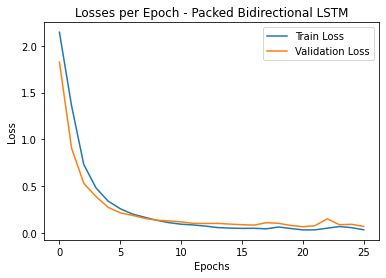

In [8]:
plot_losses(len(train_losses5), train_losses5, val_losses5, title = 'Losses per Epoch - Packed Bidirectional LSTM')